# Часть 1. Сегментация на основе U-Net

Библиотеки

In [1]:
# #Установим keras (если необходимо)
# !pip install keras

# #Установим tensorflow (если необходимо)
# !pip install tensorflow

# #Установим библиотеку для отображения изменения accuracy и loss
# !pip install livelossplot

# #Установим метрики torch (если берем DICE из коробки)
# !pip install torchmetrics

In [ ]:
#Это необходимо заполнить для работы с telegram ботом
TOKEN = "YOUR_TOKEN"
chat_id = "YOUR_CHAT_ID"

In [1]:
#Импортируем необходимые библиотеки

import os
import time
import glob
import cv2
from imageio import imread

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.compiler.tensorrt import trt_convert as trt

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

from livelossplot.tf_keras import PlotLossesCallback
import requests

# import torch
# from torchmetrics.functional import dice

Вспомогательные функции

In [2]:
#Если работаем через google disk
#Подключимся к диску с данными
# from google.colab import drive
# drive.mount('/content/gdrive')

# images = sorted(glob.glob('/content/gdrive/MyDrive/cat_data/img/*.jpg'))
# masks = sorted(glob.glob('/content/gdrive/MyDrive/cat_data/masks_machine/*.png'))

#Список изображений и масок
images = sorted(glob.glob('./cat_data/img/*.jpg'))
masks = sorted(glob.glob('./cat_data/masks_machine/*.png'))

In [3]:
#Зададим размер batch и размер изображения
BATCH_SIZE = 16
IMG_SHAPE  = (256, 256)
OUTPUT_SIZE = (960, 1280)

#7 классов + 1 фон
CLASSES = 8

#Цвета для отображения сегментации
Colors = ['black', 'blue', 'yellow', 'cyan', 'orange', 'pink', 'red', 'green']
rgb_colors = [(0,   0,   0),(255, 0,   0),(0,   255, 0),(0,   0,   255),
              (255, 165, 0),(255, 192, 203),(0,   255, 255),(255, 0,   255)]

In [4]:
#Функция для загрузки изображения
def load_img(image, mask):

    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    #Загружаем и препроцессим маски изображений
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.grayscale_to_rgb(mask) #Если маски сохранены в GRAY
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    #Сохраним маски для каждого класса
    masks = []
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))
    return image, masks


#Аугментация изобажений
def aug_img(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    image = tf.image.resize(image, IMG_SHAPE)
    masks = tf.image.resize(masks, IMG_SHAPE)
    return image, masks


#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice


#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss


#binary_crossentropy - дает хорошую сходимость модели при сбалансированном наборе данных
#DICE - хорошо в задачах сегментации но плохая сходимость
#Плохо сбалансированные данные, но хорошие реузьтаты:
# Binary crossentropy + 0.25 * DICE

def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

# #Можно воспользоваться готовой DICE (но не очень удобно)
# preds = torch.tensor([[2, 0], [2, 1]])
# target = torch.tensor([[1, 1], [2, 0]])
# dice(y_pred, y_true, average='micro')


#Функция для подсчёта расстояния между точками
def distance_between_p(p1, p2):
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis


#Функция для отправки фото в телеграм
def send_photo_file(chat_id, img):
    files = {'photo': open(img, 'rb')}
    requests.post(f'https://api.telegram.org/bot{TOKEN}/sendPhoto?chat_id={chat_id}', files=files)

#Функция для отправки сообщения в телеграм
def send_telegram_message(message):
    requests.get(f'https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}').json()

In [5]:
#Формируем датасет
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images),
                               tf.data.Dataset.from_tensor_slices(masks)))

#Загружаем дату
dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

#Аугментация (увеличим датасет в 50 раз)
dataset = dataset.repeat(50)
dataset = dataset.map(aug_img, num_parallel_calls=tf.data.AUTOTUNE)

Вручную было размечено 42 фотографии.

Имеются следующие метки класса:
- Кот
- Кошачья голова (выкл)
- Стул
- Ножки стула
- Стол
- Ножки стола
- Тарелка
- Фон

In [15]:
#Размер train выборки
train_size = 1800

#Делим на train и test
train_dataset = dataset.take(train_size).cache()
test_dataset = dataset.skip(train_size).take(len(dataset) - train_size).cache()

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Модель U-Net ##

In [16]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = tf.keras.layers.Input(shape=image_size + (3,))
    conv_1 = tf.keras.layers.Conv2D(64, 4, activation=tf.keras.layers.LeakyReLU(),
                                    strides=2, padding='same', kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    conv_1_1 = tf.keras.layers.Conv2D(128, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_1_1)

    #2
    conv_2 = tf.keras.layers.Conv2D(256, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_2)

    #3
    conv_3 = tf.keras.layers.Conv2D(512, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization()(conv_3)

    #4
    conv_4 = tf.keras.layers.Conv2D(512, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_3)
    batch_norm_4 = tf.keras.layers.BatchNormalization()(conv_4)

    #5
    conv_5 = tf.keras.layers.Conv2D(512, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_4)
    batch_norm_5 = tf.keras.layers.BatchNormalization()(conv_5)

    #6
    conv_6 = tf.keras.layers.Conv2D(512, 4, activation=tf.keras.layers.LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_5)


    #Разворачиваем
    #1
    up_1 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = tf.keras.layers.BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = tf.keras.layers.Dropout(0.25)(batch_up_1)

    #2
    up_2 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = tf.keras.layers.BatchNormalization()(up_2)
    batch_up_2 = tf.keras.layers.Dropout(0.25)(batch_up_2)




    #3
    up_3 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = tf.keras.layers.BatchNormalization()(up_3)
    batch_up_3 = tf.keras.layers.Dropout(0.25)(batch_up_3)




    #4
    up_4 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = tf.keras.layers.BatchNormalization()(up_4)


    #5
    up_5 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = tf.keras.layers.BatchNormalization()(up_5)


    #6
    up_6 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = tf.keras.layers.BatchNormalization()(up_6)


    #Выходной слой
    output_layer = tf.keras.layers.Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [21]:
#Иницилизируем модель
COT_model = unet_model(IMG_SHAPE, CLASSES)

tf.keras.utils.plot_model(COT_model, show_shapes=True)

In [22]:
#Компилируем модель
COT_model.compile(optimizer='adam',
                  loss=[dice_bce_loss],
                  metrics=[dice_coef])

COT_model.summary()

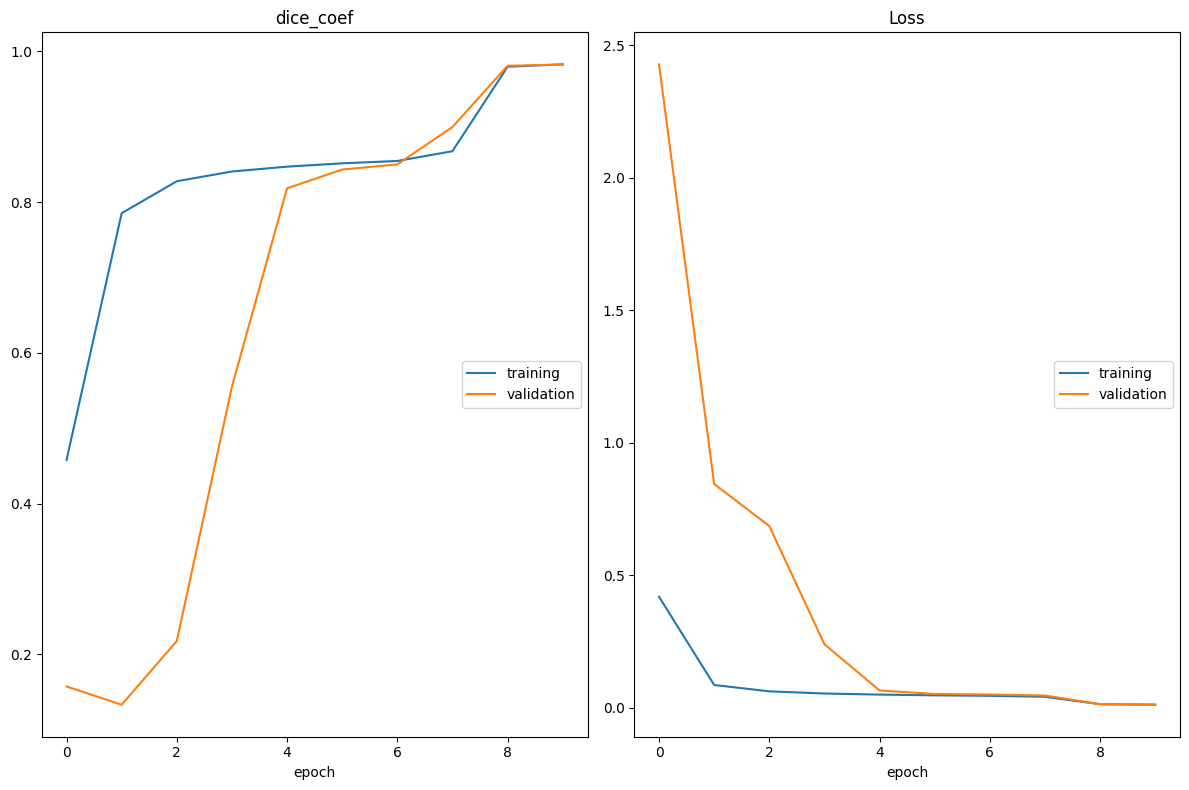

dice_coef
	training         	 (min:    0.458, max:    0.983, cur:    0.983)
	validation       	 (min:    0.133, max:    0.983, cur:    0.983)
Loss
	training         	 (min:    0.011, max:    0.418, cur:    0.011)
	validation       	 (min:    0.012, max:    2.427, cur:    0.012)
113/113 [==============================] - 38s 332ms/step - loss: 0.0113 - dice_coef: 0.9828 - val_loss: 0.0120 - val_dice_coef: 0.9825


In [12]:
EPOCHS = 10

#Обучение
COT_model.fit(train_dataset,
              validation_data=test_dataset,
              epochs=EPOCHS, initial_epoch=0,
              callbacks=[PlotLossesCallback()])

In [ ]:
#Сохранить веса модели
# COT_model.save('/content/gdrive/MyDrive/cat_data/networks/checkpoint_best_unet_like_model_10epochs')
COT_model.save('./cat_data/networks/checkpoint_best_unet_like_model_10epochs')

# Часть 2. Рабочий функционал по детектированию сближения двух классов сегментации

Теперь имея рабочую модель сегментации, построим основной функционал оповещения при приближении кота к котлетам.

In [ ]:
#Загрузить модель
# COT_model.load_weights('/content/gdrive/MyDrive/cat_data/networks/checkpoint_best_unet_like_model_10epochs')
COT_model.load_weights('./cat_data/networks/checkpoint_best_unet_like_model_10epochs')

In [ ]:
#Тестовое видео
video_path = './cat_data/test_video/telegram-cloud-document-2-5237884420458820547.mp4'

In [ ]:
cat_on_table = False
no_more_food = False

#Дистаниции до стола и критическая:)
dist_to_table = 170
dist_critical = 140

#Сообщение в телеграм?
telegram_message_cat_on_table = False
telegram_message_no_more_food = False

#Инициализируем работу с видео
video_capture = cv2.VideoCapture(video_path)

#Пока не нажата клавиша q функция будет работать
while video_capture.isOpened():

    ret, image_to_process = video_capture.read()

    #BGR to RGB
    image_to_process_reversed = image_to_process[:, :, ::-1]

    sample = resize(image_to_process_reversed, IMG_SHAPE)
    predict = COT_model.predict(sample.reshape((1,) +  IMG_SHAPE + (3,)))
    predict = predict.reshape(IMG_SHAPE + (CLASSES,))

    scale = image_to_process_reversed.shape[0] / IMG_SHAPE[0], image_to_process_reversed.shape[1] / IMG_SHAPE[1]

    frame = (image_to_process_reversed / 1.5).astype(np.uint8)
    frame_to_telegram = frame

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]), 0.8)

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0], contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

        
    #Контур кота и тарелки
    contours_plate = measure.find_contours(np.array(frame[:,:,1]), 0.5)
    contours_cat = measure.find_contours(np.array(frame[:,:,2]), 0.5)
    if len(contours_plate) != 0:
        
        #Принимается, что кот справа от тарелки
        #Координаты центральной точки тарелки (Танцы с бубном)
        plate_coord_index_max = np.where( contours_plate[0][:,1] == max(contours_plate[0][:,1]) )[0][0]
        plate_coord_max = contours_plate[0][plate_coord_index_max:][0]    
        plate_coord_index_min = np.where( contours_plate[0][:,1] == min(contours_plate[0][:,1]) )[0][0]
        plate_coord_min = contours_plate[0][plate_coord_index_min:][0]    
        plate_coord_X = int((plate_coord_max[1]+plate_coord_min[1])/2)
        plate_coord = plate_coord_max[0], plate_coord_X

        #Координаты крайней точки кота
        cat_coord_index = np.where( contours_cat[0][:,1] == min(contours_cat[0][:,1]) )[0][0]
        cat_coord = contours_cat[0][cat_coord_index:][0]   

        #Защита от плохой сегментации
        if (cat_coord[0] < 10) & (cat_coord[1] > plate_coord[1]):
            cat_coord_index = np.where( contours_cat[2][:,1] == min(contours_cat[2][:,1]) )[0][0]
            cat_coord = contours_cat[2][cat_coord_index:][0]  

        #Определим расстояние между точками
    dist = distance_between_p((plate_coord[1], plate_coord[0]), (cat_coord[1], cat_coord[0]))
    
    #Кот на столе
    if dist <= dist_to_table:
        """Кот на столе"""
        cat_on_table = True
    
    #Кот в котлетах
    if dist <= dist_critical:
        """Котлеты дискредитированы"""
        no_more_food = True
    
    
    if (no_more_food == False) & (cat_on_table==False):
        #Точки тарелки и кота
        frame_result = cv2.circle(frame, (int(plate_coord[1]),int(plate_coord[0])), 2, (0, 255, 0), 3)
        frame_result = cv2.circle(frame, (int(cat_coord[1]),int(cat_coord[0])), 2, (255, 0, 0), 3)

        #Отрисовать линию от кота до котлет
        cv2.line(frame_result, (int(plate_coord[1]),int(plate_coord[0])), 
                 (int(cat_coord[1]),int(cat_coord[0])), (0,255,0), 2)

        #Напишим расстояние между двумя точками
        cv2.putText(frame_result, str(round(dist)),  (int((int(plate_coord[1])+int(cat_coord[1])) / 2) ,
                                            int((int(plate_coord[0])+int(cat_coord[0])) / 2) ), 
                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,200), 2)
        
    elif cat_on_table and no_more_food:
        frame_result = frame
        cv2.putText(frame_result, 'NO MORE FOOD, MAN', (100, 256), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
        
    elif cat_on_table:
        #Точки тарелки и кота
        frame_result = cv2.circle(frame, (int(plate_coord[1]),int(plate_coord[0])), 2, (0, 255, 0), 3)
        frame_result = cv2.circle(frame, (int(cat_coord[1]),int(cat_coord[0])), 2, (255, 0, 0), 3)

        #Отрисовать линию от кота до котлет
        cv2.line(frame_result, (int(plate_coord[1]),int(plate_coord[0])), 
                 (int(cat_coord[1]),int(cat_coord[0])), (0,255,0), 2)

        #Напишим расстояние между двумя точками
        cv2.putText(frame_result, str(round(dist)),  (int((int(plate_coord[1])+int(cat_coord[1])) / 2) ,
                                            int((int(plate_coord[0])+int(cat_coord[0])) / 2) ), 
                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,200), 2)
        
        cv2.putText(frame_result, 'CAT ON THE TABLE', (100, 256), 
                 cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3)
        
      
    #BGR to RGB
    frame_result = frame_result[:, :, ::-1]
    
    #Отправка сообщения в телеграмм бот
    if not telegram_message_cat_on_table and cat_on_table:
        message_tel = f'Пушистый приближается! Он на рассотянии {round(dist)} от котлет!!!'
        send_telegram_message(message_tel)
        telegram_message_cat_on_table = True
    
    if not telegram_message_no_more_food and no_more_food:
        message_tel = 'Можешь не торопиться, котлеты дискредитированы!'
        send_telegram_message(message_tel)
        cv2.imwrite('./image_test_free.png', frame_to_telegram)
        send_photo_file(chat_id, './image_test_free.png')   
        telegram_message_no_more_food = True
    
    #Показать результат работы
    cv2.imshow('Cat', frame_result)

    #Прерывание работы клавишей q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        #Очищаем всё после завершения.
        video_capture.release()
        cv2.destroyAllWindows()
        break